In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import StepLR

class CustomLoss(nn.Module):
    def __init__(self, inputs):
        super(CustomLoss, self).__init__()
        self.inputs = inputs

    def forward(self, y_pred, y_true):
        N = y_pred
        t = self.inputs
        first_term = (t**2) * torch.autograd.grad(torch.autograd.grad(N, t, torch.ones_like(N), create_graph=True)[0], t, torch.ones_like(N), create_graph=True)[0]
        second_term = 4 * t * torch.autograd.grad(N, t, torch.ones_like(N), create_graph=True)[0]
        third_term = (2.0 + t**2) * N
        res = first_term + second_term + third_term + 1.0
        return torch.mean(torch.square(res), dim=0)

t = np.linspace(0, 2 * np.pi, 500).reshape(-1, 1)
t = torch.tensor(t, dtype=torch.float32, requires_grad=True)

model = nn.Sequential(
    nn.Linear(1, 1000),
    nn.Sigmoid(),
    nn.Linear(1000, 1, bias=False)
)

criterion = CustomLoss(t)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Dynamic learning rate
scheduler = StepLR(optimizer, step_size=3000, gamma=0.1)  # Decrease learning rate by a factor of 0.1 every 3000 epochs

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    outputs = model(t)
    loss = criterion(outputs, t)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update learning rate
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/10000], Loss: {loss.item()}, Learning Rate: {scheduler.get_last_lr()[0]}')


Epoch [1/10000], Loss: 110.19242095947266, Learning Rate: 0.01
Epoch [101/10000], Loss: 0.274648517370224, Learning Rate: 0.01
Epoch [201/10000], Loss: 0.06171761453151703, Learning Rate: 0.01
Epoch [301/10000], Loss: 0.055504802614450455, Learning Rate: 0.01
Epoch [401/10000], Loss: 0.0504707433283329, Learning Rate: 0.01
Epoch [501/10000], Loss: 0.045876406133174896, Learning Rate: 0.01
Epoch [601/10000], Loss: 0.04143606498837471, Learning Rate: 0.01
Epoch [701/10000], Loss: 0.03713757172226906, Learning Rate: 0.01
Epoch [801/10000], Loss: 0.03304717689752579, Learning Rate: 0.01
Epoch [901/10000], Loss: 0.02923283353447914, Learning Rate: 0.01
Epoch [1001/10000], Loss: 0.02574561908841133, Learning Rate: 0.01
Epoch [1101/10000], Loss: 0.022617077454924583, Learning Rate: 0.01
Epoch [1201/10000], Loss: 0.01985897496342659, Learning Rate: 0.01
Epoch [1301/10000], Loss: 0.01746460609138012, Learning Rate: 0.01
Epoch [1401/10000], Loss: 0.01541087869554758, Learning Rate: 0.01
Epoch [1

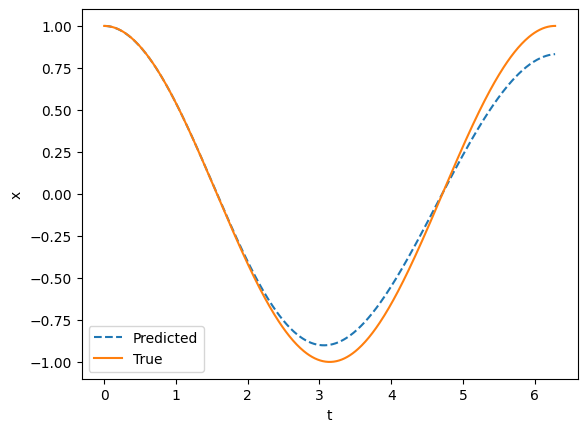

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    t_detached = t.detach().numpy()  # Detach t
    t_squared = (t**2).detach().numpy()  # Detach after squaring
    x_pred = 1 + t_squared * model(t).detach().numpy()

x_true = np.cos(t_detached)

# Plot predicted values
plt.plot(t_detached, x_pred, '--', label='Predicted') #numerical solution

# Plot true values
plt.plot(t_detached, x_true, label='True') #analytical solution

plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()